This script offers a preliminary evaluation of a variant of the motif graph learning algorithm that considers the observations follow a GMRF whose precision matrix is given by a polynomial of the GSO.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

from sklearn.covariance import graphical_lasso
import src.utils as utils
import spectral_nti as snti

SEED = 28
N_CPUS = cpu_count()
np.random.seed(SEED)

PATH = './results/gmrf_st/'

## Auxiliary functions

In [2]:
def est_graph(id, models, MM, L, K, iters, verb=False):
    X = utils.create_GMRF_st_signals(L, K, MM[-1])

    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i, M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()

            if model['name'] == 'GLasso':
                try:
                    _, L_hat = graphical_lasso(C_hat, model['alpha'], max_iter=iters)
                except FloatingPointError:
                    L_hat = np.zeros((N,N))
            elif model['St']:
                L_hat, _ = snti.MGL_Stationary_GMRF(C_hat, model['gs'], model['bounds'], 
                                                    model['cs'], model['regs'], max_iters=iters,
                                                    verbose=verb, epsilon=1e-5)
            else:
                L_hat, _ = snti.MGL(C_hat, model['gs'], model['bounds'], 
                                    model['cs'], model['regs'], max_iters=iters,
                                    verbose=verb, epsilon=1e-5)

            lamd_hat[:,j,i], _ = np.linalg.eigh(L_hat) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {}-{} - Time(sec): {:.3}'.format(id, M, model['name'],  model['St'], t))
    return A_hat, lamd_hat


def est_errs(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def est_errs2(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                err_A[j,i,k] = np.linalg.norm(A-A_hat[:,:,j,i,k],'fro')/norm_A
                err_lamb[j,i,k] = np.linalg.norm(lamd/-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))

## Create graphs

Norm of A: 7.874007874011811
Norm of lambdas: 16.24807680927192


Text(0.5, 1.0, 'True Lambdas, N: 20')

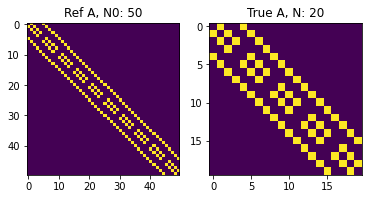

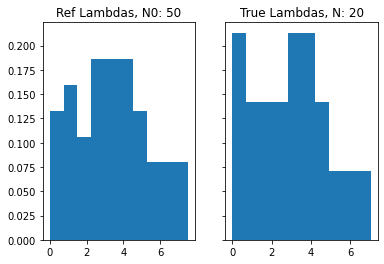

In [3]:
# Ref graph
n01 = 10
n02 = 5
N0 = n01*n02
A0 = nx.to_numpy_array(nx.grid_2d_graph(n01, n02))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)

# Target graph
n1 = 5
n2 = 4
N = n1*n2
A = nx.to_numpy_array(nx.grid_2d_graph(n1, n2))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

In [4]:
plt.rcParams['figure.facecolor'] = 'white'

## Compare contraints

In [5]:
n_covs = 50  #100
#MM = np.arange(300, 1501, 100)
MM = [100, 150, 200, 250, 300, 350, 400]
K = 4
iters = 50 # 30

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(cp.sqrt(a))/b,
    lambda a, b : cp.sum((.5*a-.75)**2)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-.5*lamd_t).T@lamd,
]

deltas = [.3, 2.1, .003, .1, .35]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    # Baseline
    {'St': False, 'name': 'GLasso', 'alpha': 0.1, 'fmt': '^:'},


    # With Stationarity
    {'St': True, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'eta': 1, 'inc_eta': 1.1,
              'deltas': deltas[0]}},

    {'St': True, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'eta': .05, 'inc_eta': 1.1,
              'deltas': deltas[1]}},

    {'St': True, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'eta': .1, 'inc_eta': 1.1, 
              'deltas': deltas[4]}},

    # Without Stationarity
    {'St': False, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'deltas': deltas[0]}},

    {'St': False, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o--',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'deltas': deltas[1]}},

    {'St': False, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'deltas': deltas[4]}},
]

	c-0: c: 3.100	c0: 3.400	err: -0.300000	err norm: -0.088235
	c-1: c: 13.200	c0: 15.360	err: -2.160000	err norm: -0.140625
	c-2: c: 0.125	c0: 0.125	err: -0.000055	err norm: -0.000437
	c-3: c: 1.636	c0: 1.735	err: -0.099287	err norm: -0.057224
	c-4: c: 1.509	c0: 1.841	err: -0.331875	err norm: -0.180244


In [6]:
# Estimate graph
verbose = False

total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, K, iters, verbose) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 64


Cov-0, M-100: Model: GLasso-False - Time(sec): 0.00758
Cov-20, M-100: Model: GLasso-False - Time(sec): 0.00415
Cov-19, M-100: Model: GLasso-False - Time(sec): 0.00978
Cov-18, M-100: Model: GLasso-False - Time(sec): 0.00558
Cov-10, M-100: Model: GLasso-False - Time(sec): 0.0197
Cov-9, M-100: Model: GLasso-False - Time(sec): 0.00638
Cov-31, M-100: Model: GLasso-False - Time(sec): 0.0102
Cov-1, M-100: Model: GLasso-False - Time(sec): 0.0066
Cov-13, M-100: Model: GLasso-False - Time(sec): 0.0054
Cov-34, M-100: Model: GLasso-False - Time(sec): 0.00535
Cov-3, M-100: Model: GLasso-False - Time(sec): 0.0123
Cov-33, M-100: Model: GLasso-False - Time(sec): 0.00932
Cov-2, M-100: Model: GLasso-False - Time(sec): 0.0127
Cov-12, M-100: Model: GLasso-False - Time(sec): 0.0121
Cov-6, M-100: Model: GLasso-False - Time(sec): 0.0107
Cov-4, M-100: Model: GLasso-False - Time(sec): 0.0126
Cov-45, M-100: Model: GLasso-False - Time(sec): 0.00416
Cov-5, M-100: Model: GLasso-False - Time(sec): 0.0247
Cov-7, M-1

/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:261: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119506.70150828129, tolerance: 24.043576177413062
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:261: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 23.586459552269545
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:261: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 23.922633142609858
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:261: ConvergenceWarning: Objective did not converge. You

Cov-22, M-100: Model: GLasso-False - Time(sec): 0.0146
Cov-23, M-100: Model: GLasso-False - Time(sec): 0.0103
Cov-25, M-100: Model: GLasso-False - Time(sec): 0.013
Cov-26, M-100: Model: GLasso-False - Time(sec): 0.00684
Cov-37, M-100: Model: GLasso-False - Time(sec): 0.00663
Cov-29, M-100: Model: GLasso-False - Time(sec): 0.00728
Cov-36, M-100: Model: GLasso-False - Time(sec): 0.00559
Cov-40, M-100: Model: GLasso-False - Time(sec): 0.0107
Cov-17, M-100: Model: GLasso-False - Time(sec): 0.0886
Cov-32, M-100: Model: GLasso-False - Time(sec): 0.0442
Cov-38, M-100: Model: GLasso-False - Time(sec): 0.0087
Cov-35, M-100: Model: GLasso-False - Time(sec): 0.0146
Cov-39, M-100: Model: GLasso-False - Time(sec): 0.00662
Cov-47, M-100: Model: GLasso-False - Time(sec): 0.00715
Cov-42, M-100: Model: GLasso-False - Time(sec): 0.00735
Cov-43, M-100: Model: GLasso-False - Time(sec): 0.00908
Cov-44, M-100: Model: GLasso-False - Time(sec): 0.0168
Cov-46, M-100: Model: GLasso-False - Time(sec): 0.00885
Co

/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/prob

Cov-36, M-100: Model: Tr-True - Time(sec): 17.6
Cov-14, M-100: Model: Tr-True - Time(sec): 21.9
Cov-11, M-100: Model: Tr-True - Time(sec): 23.3
Cov-45, M-100: Model: Tr-True - Time(sec): 25.4
Cov-29, M-100: Model: Tr-True - Time(sec): 26.6
Cov-27, M-100: Model: Tr-True - Time(sec): 27.4
Cov-46, M-100: Model: Tr-True - Time(sec): 27.3
Cov-42, M-100: Model: Tr-True - Time(sec): 28.2
Cov-20, M-100: Model: Tr-True - Time(sec): 28.7
Cov-16, M-100: Model: Tr-True - Time(sec): 28.7
Cov-3, M-100: Model: Tr-True - Time(sec): 29.9
Cov-43, M-100: Model: Tr-True - Time(sec): 32.1
Cov-19, M-100: Model: Tr-True - Time(sec): 32.7
Cov-38, M-100: Model: Tr-True - Time(sec): 32.7
Cov-4, M-100: Model: Tr-True - Time(sec): 34.4
Cov-36, M-100: Model: Sq-True - Time(sec): 18.6
Cov-40, M-100: Model: Tr-True - Time(sec): 37.2
Cov-37, M-100: Model: Tr-True - Time(sec): 37.6
Cov-6, M-100: Model: Tr-True - Time(sec): 37.9
Cov-23, M-100: Model: Tr-True - Time(sec): 38.8
Cov-28, M-100: Model: Tr-True - Time(sec): 

/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-36, M-100: Model: BR-False - Time(sec): 0.705
Cov-36, M-200: Model: GLasso-False - Time(sec): 0.00737
Cov-7, M-100: Model: Tr-True - Time(sec): 59.1
Cov-31, M-100: Model: Tr-True - Time(sec): 59.9
Cov-39, M-100: Model: Tr-True - Time(sec): 59.8


/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-42, M-100: Model: Sq-True - Time(sec): 33.0
Cov-35, M-100: Model: Tr-True - Time(sec): 62.0
Cov-41, M-100: Model: Tr-True - Time(sec): 62.3
Cov-10, M-100: Model: Tr-True - Time(sec): 64.1
Cov-14, M-100: Model: BR-True - Time(sec): 18.6
Cov-14, M-100: Model: Tr-False - Time(sec): 0.595
Cov-14, M-100: Model: Sq-False - Time(sec): 0.711
Cov-45, M-100: Model: BR-True - Time(sec): 18.8
Cov-45, M-100: Model: Tr-False - Time(sec): 0.591
Cov-14, M-100: Model: BR-False - Time(sec): 0.687
Cov-14, M-200: Model: GLasso-False - Time(sec): 0.00604
Cov-45, M-100: Model: Sq-False - Time(sec): 0.738
Cov-46, M-100: Model: BR-True - Time(sec): 18.3
Cov-45, M-100: Model: BR-False - Time(sec): 0.697
Cov-45, M-200: Model: GLasso-False - Time(sec): 0.00557
Cov-46, M-100: Model: Tr-False - Time(sec): 0.601
Cov-46, M-100: Model: Sq-False - Time(sec): 0.715
Cov-46, M-100: Model: BR-False - Time(sec): 0.682
Cov-46, M-200: Model: GLasso-False - Time(sec): 0.0056
Cov-20, M-100: Model: BR-True - Time(sec): 20.6

/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 1.434e-03
  warnings.warn(


Cov-15, M-200: Model: Tr-True - Time(sec): 73.5
Cov-48, M-200: Model: Tr-True - Time(sec): 90.0
Cov-2, M-200: Model: Tr-True - Time(sec): 1.1e+02
Cov-16, M-200: Model: Sq-True - Time(sec): 71.9
Cov-12, M-200: Model: Tr-True - Time(sec): 96.5
Cov-6, M-200: Model: Tr-True - Time(sec): 90.7
Cov-37, M-200: Model: Tr-True - Time(sec): 1.08e+02
Cov-35, M-200: Model: Tr-True - Time(sec): 91.0
Cov-17, M-200: Model: Tr-True - Time(sec): 93.0
Cov-9, M-200: Model: Tr-True - Time(sec): 97.6
Cov-23, M-200: Model: Tr-True - Time(sec): 1.13e+02
Cov-21, M-200: Model: Tr-True - Time(sec): 1.08e+02
Cov-29, M-200: Model: Sq-True - Time(sec): 94.2
Cov-16, M-200: Model: BR-True - Time(sec): 23.2
Cov-16, M-200: Model: Tr-False - Time(sec): 0.607
Cov-16, M-200: Model: Sq-False - Time(sec): 0.669
Cov-16, M-200: Model: BR-False - Time(sec): 0.695
Cov-16, M-300: Model: GLasso-False - Time(sec): 0.00567
Cov-3, M-200: Model: Tr-True - Time(sec): 1.3e+02
Cov-40, M-200: Model: Tr-True - Time(sec): 1e+02
Cov-24, M-2

/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.426e-03
  warnings.warn(


Cov-10, M-300: Model: GLasso-False - Time(sec): 0.084
Cov-16, M-300: Model: Sq-False - Time(sec): 0.482
Cov-16, M-300: Model: BR-False - Time(sec): 0.492
Cov-16, M-400: Model: GLasso-False - Time(sec): 0.00429
Cov-47, M-300: Model: Tr-True - Time(sec): 1.03e+02
Cov-13, M-300: Model: Tr-True - Time(sec): 1.67e+02
Cov-34, M-200: Model: Sq-True - Time(sec): 1.63e+02
CONVERGENCE AT ITERATION: 15
Cov-3, M-300: Model: Tr-True - Time(sec): 1.09e+02
CONVERGENCE AT ITERATION: 1
Cov-30, M-200: Model: BR-True - Time(sec): 25.4
CONVERGENCE AT ITERATION: 44
Cov-46, M-300: Model: Sq-True - Time(sec): 43.1
Cov-48, M-300: Model: Tr-True - Time(sec): 89.2
Cov-30, M-200: Model: Tr-False - Time(sec): 0.607
Cov-30, M-200: Model: Sq-False - Time(sec): 0.717
Cov-30, M-200: Model: BR-False - Time(sec): 0.68
Cov-30, M-300: Model: GLasso-False - Time(sec): 0.016
CONVERGENCE AT ITERATION: 11
Cov-16, M-400: Model: Tr-True - Time(sec): 7.21
CONVERGENCE AT ITERATION: 25
Cov-29, M-300: Model: Sq-True - Time(sec): 3

/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.610e-03
  warnings.warn(


Cov-44, M-400: Model: BR-False - Time(sec): 0.416
CONVERGENCE AT ITERATION: 21
Cov-5, M-300: Model: BR-True - Time(sec): 12.3
Cov-30, M-300: Model: BR-True - Time(sec): 31.0
Cov-5, M-300: Model: Tr-False - Time(sec): 0.362
Cov-30, M-300: Model: Tr-False - Time(sec): 0.36
Cov-5, M-300: Model: Sq-False - Time(sec): 0.406
Cov-30, M-300: Model: Sq-False - Time(sec): 0.404
Cov-5, M-300: Model: BR-False - Time(sec): 0.415
Cov-5, M-400: Model: GLasso-False - Time(sec): 0.0111
Cov-30, M-300: Model: BR-False - Time(sec): 0.413
Cov-30, M-400: Model: GLasso-False - Time(sec): 0.0203
CONVERGENCE AT ITERATION: 39
Cov-39, M-300: Model: Sq-True - Time(sec): 84.2
CONVERGENCE AT ITERATION: 24
Cov-17, M-300: Model: BR-True - Time(sec): 15.0
Cov-17, M-300: Model: Tr-False - Time(sec): 0.358
Cov-17, M-300: Model: Sq-False - Time(sec): 0.402
Cov-17, M-300: Model: BR-False - Time(sec): 0.412
Cov-17, M-400: Model: GLasso-False - Time(sec): 0.0384
Cov-0, M-400: Model: Tr-True - Time(sec): 35.9
Cov-25, M-400: 

/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -1.173e-02
  warnings.warn(


Cov-32, M-200: Model: Tr-True - Time(sec): 2.23e+02
Cov-32, M-200: Model: Sq-True - Time(sec): 1.39e+02
Cov-32, M-200: Model: BR-True - Time(sec): 1.11e+02
Cov-32, M-200: Model: Tr-False - Time(sec): 0.345
Cov-32, M-200: Model: Sq-False - Time(sec): 0.385
Cov-32, M-200: Model: BR-False - Time(sec): 0.395
Cov-32, M-300: Model: GLasso-False - Time(sec): 0.0569


/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -3.118e-04
  warnings.warn(


Cov-32, M-300: Model: Tr-True - Time(sec): 2.01e+02
CONVERGENCE AT ITERATION: 41
Cov-32, M-300: Model: Sq-True - Time(sec): 1.81e+02
CONVERGENCE AT ITERATION: 25
Cov-32, M-300: Model: BR-True - Time(sec): 55.4
Cov-32, M-300: Model: Tr-False - Time(sec): 0.345
Cov-32, M-300: Model: Sq-False - Time(sec): 0.386
Cov-32, M-300: Model: BR-False - Time(sec): 0.395
Cov-32, M-400: Model: GLasso-False - Time(sec): 0.0572


/usr/local/lib/python3.8/dist-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -3.357e-03
  warnings.warn(


Cov-32, M-400: Model: Tr-True - Time(sec): 96.8
CONVERGENCE AT ITERATION: 5
Cov-32, M-400: Model: Sq-True - Time(sec): 12.2
CONVERGENCE AT ITERATION: 13
Cov-32, M-400: Model: BR-True - Time(sec): 24.1
Cov-32, M-400: Model: Tr-False - Time(sec): 0.365
Cov-32, M-400: Model: Sq-False - Time(sec): 0.385
Cov-32, M-400: Model: BR-False - Time(sec): 0.394
Cov-1, M-100: Model: Tr-True - Time(sec): 2.05e+03
Cov-1, M-100: Model: Sq-True - Time(sec): 1.84e+03


/tmp/ipykernel_4134953/1902289996.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


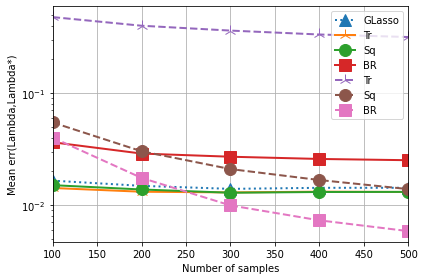

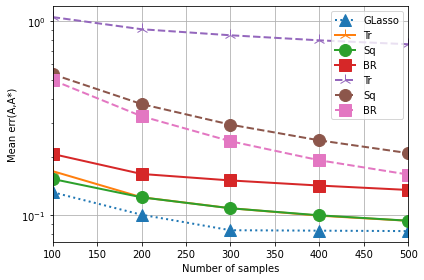

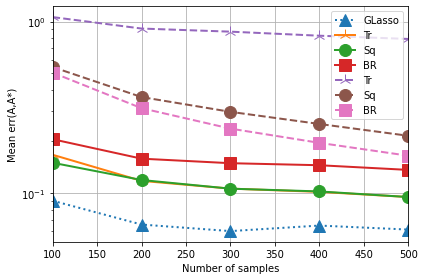

In [ ]:
err_A, err_lamd = est_errs(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A:med.png')



/tmp/ipykernel_4134953/1902289996.py:73: RuntimeWarning: divide by zero encountered in true_divide
  err_lamb[j,i,k] = np.linalg.norm(lamd/-lams_hat[:,j,i,k], 2)/norm_lam
/tmp/ipykernel_4134953/1902289996.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


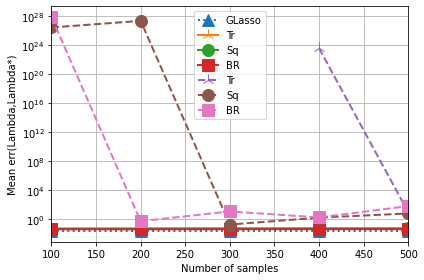

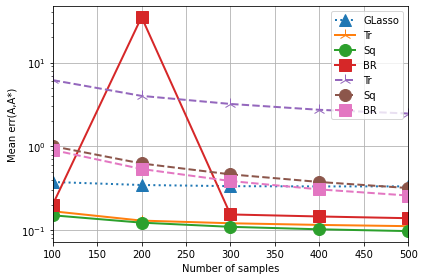

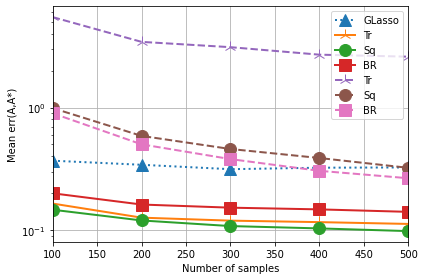

In [ ]:
err_A, err_lamd = est_errs2(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb2.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A2.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A_med2.png')



In [ ]:
# Save np data
models_aux = [{'name': model['name'], 'St': model['St'], 'fmt': model['fmt']}
                for model in models]
data = {
    'A': A,
    'lambdas': lambdas,
    'lambdas0': lambdas0,
    'As_hat': As_hat,
    'lamds_hat': lamds_hat,
    'MM': MM,
    'models': models_aux
}
file = 'st_lattice_{}covs_{}iters'.format(n_covs, iters)
np.save(PATH + file, data)


: 

In [ ]:
# Save data as csv
# fname = PATH + 'constraints.csv'
# utils.error_to_csv(fname, models, MM, mean_err_lam)


In [ ]:
# %matplotlib qt

# # Load data
# file = 'results/constraints/constraints_100covs_200iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# lambdas0 = data['lambdas0']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']